<a href="https://colab.research.google.com/github/kkmcgg/lasnerf/blob/main/Crystalgraph3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install laspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
def print_stats(x):
  if len(x.shape) == 2:
    for i in range(x.shape[1]):
      print(i,x[:,i].min(),x[:,i].mean(), x[:,i].max())
  else:
    print(0,x.min(),x.mean(), x.max())
  print('')


Load Las

In [ ]:
import laspy


las = laspy.read(r'/content/200-331025193.las')
pts = las.points[las.classification != 42]
# pts = las.points[las.classification == 40]
# pts = las.points[las.intensity < 65510]
# pts = pts[pts.classification == 40]


pcount = 1000000000 #lower this to train on a smaller subset of points

lx = pts.x.copy()
lx = lx - lx.min()
lx = lx/lx.max()
ly = pts.y.copy()
ly = ly - ly.min()
ly = ly/ly.max()
lz = pts.z.copy()
lz = lz - lz.min()
lz = lz/lz.max()

X = np.vstack((lx, ly, lz)).T[0:pcount]
intensity = pts.intensity.copy()[0:pcount]

intensity = np.log(intensity+1)
intensity = intensity - intensity.min()
intensity = intensity/intensity.max()

print_stats(X)
print_stats(intensity)

0 0.0 0.48993200215088567 1.0
1 0.0 0.4788623295920763 1.0
2 0.0 0.7418946416307921 1.0

0 0.0 0.53871316 1.0



Make Model

In [ ]:
import numpy as np
# import skimage
# import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as kl


# # Make a meshgrid
# normalized_grid = (np.mgrid[:img.shape[0], :img.shape[1]] / len(img))


# print(normalized_grid.shape)

# X = normalized_grid.reshape((2, -1)).T.astype("f4") * 2 - 1

# X = np.vstack((X[:,0],X[:,1],X[:,1])).T

# print(X.shape)

# X *= 32 # this scaling factor make the training easier
# y = img.reshape((-1, 1)) #3 for rgb, 1 for grey

def make_model(activation,inputs=3):
    return keras.Sequential([
        kl.InputLayer((inputs,)),
        kl.Dense(300),
        activation(),
        kl.Dense(300),
        activation(),
        kl.Dense(300),
        activation(),
        kl.Dense(1), #1 for greyscale, 3 for rgb
        kl.Activation(tf.nn.sigmoid)
    ])
# The gaussian activation function from the paper
activation = lambda: kl.Activation(lambda x: tf.math.exp(-x*x))

model = make_model(activation)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 300)               1200      
                                                                 
 activation_4 (Activation)   (None, 300)               0         
                                                                 
 dense_5 (Dense)             (None, 300)               90300     
                                                                 
 activation_5 (Activation)   (None, 300)               0         
                                                                 
 dense_6 (Dense)             (None, 300)               90300     
                                                                 
 activation_6 (Activation)   (None, 300)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

Make Dark Data

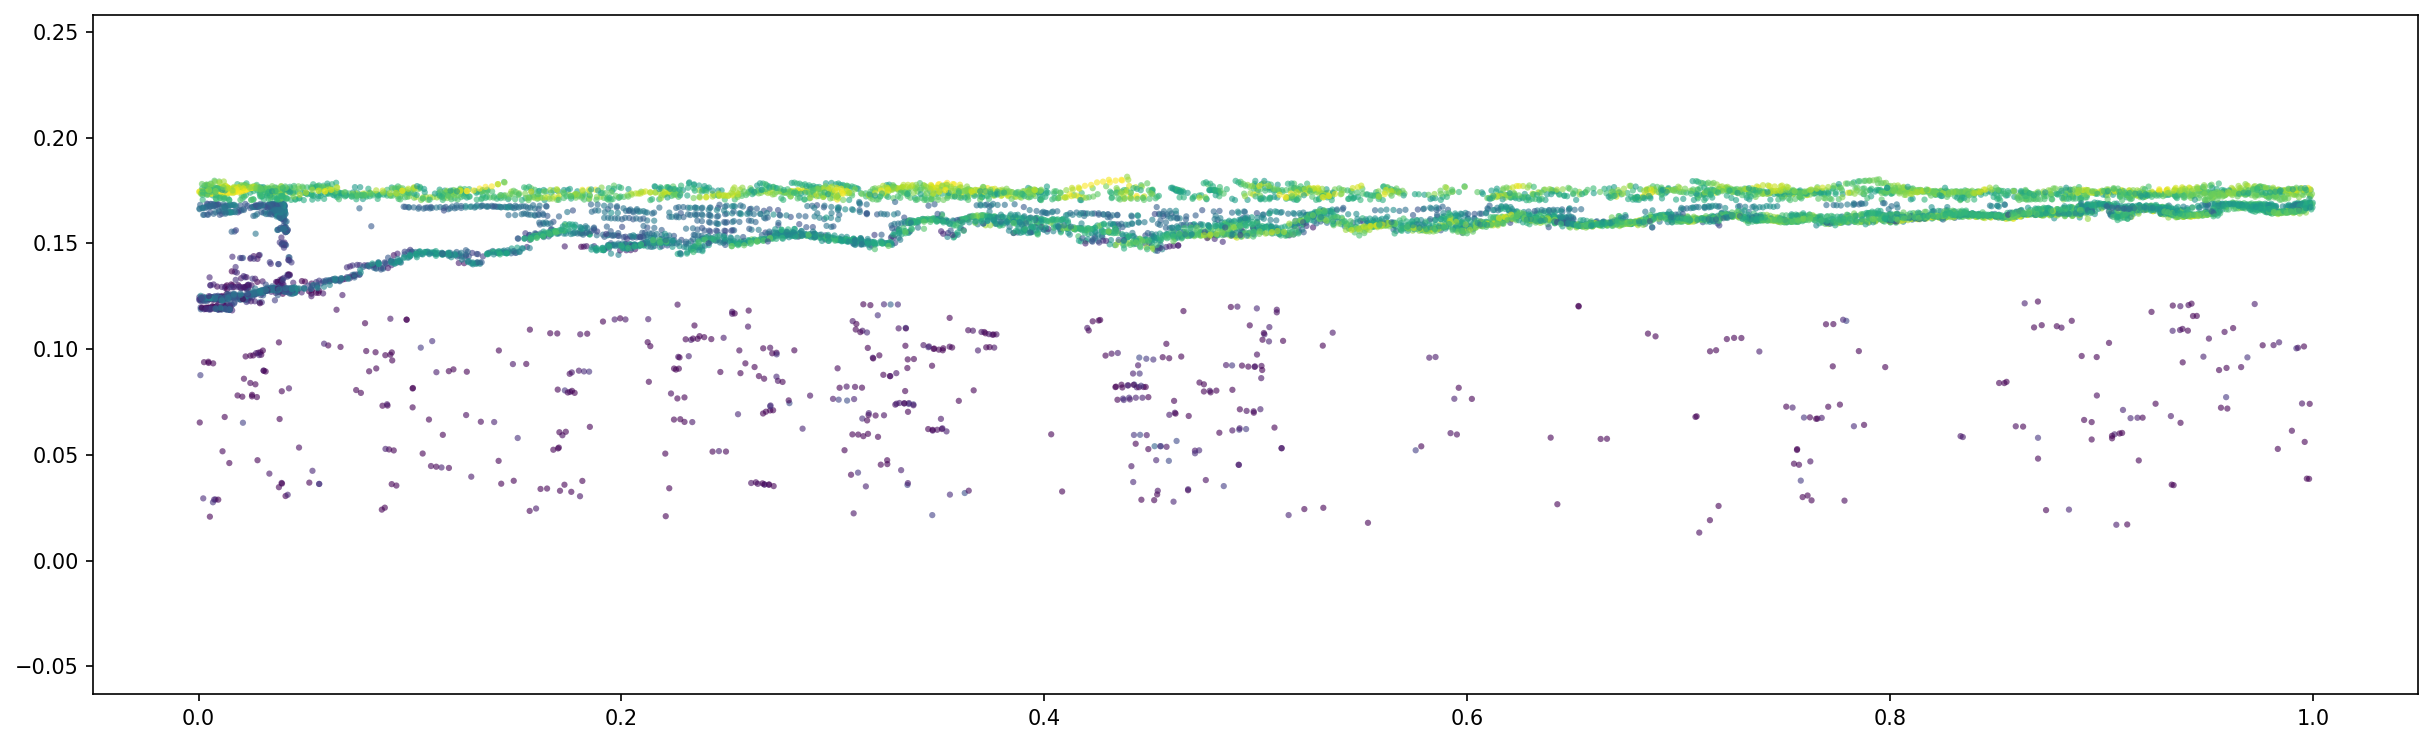

In [ ]:
import matplotlib.pyplot as plt

lasx = X[:,0]
lasy = X[:,1]
lasz = X[:,2]/10
secX = np.where(lasx < 1/200)

plt.rcParams['figure.dpi'] = 150
fig=plt.figure(figsize=(20, 6))
plt.axis('equal')
plt.scatter(lasy[secX],lasz[secX]*2, c = intensity[secX], alpha=.6,vmin=.2, vmax=.9, marker = '.',edgecolor='none')
# plt.scatter(sampY3[subX3],sampZ3[subX3]*2, c = y_pred3dark[subX3], alpha=.6,vmin=.2, vmax=.9, marker = '.',edgecolor='none')

In [ ]:
sampN = 50000
# model2.summary()
xmin,xmax = X[:,0].min(),X[:,0].max()
ymin,ymax = X[:,1].min(),X[:,1].max()
zmin,zmax = X[:,2].min(),X[:,2].max()

print(intensity.size)

# darkN = 50000
darkN = intensity.size
darkX = np.random.uniform(xmin,xmax,sampN)
darkY = np.random.uniform(ymin,ymax,sampN)
darkZ = np.random.uniform(zmin,zmax,sampN)
dark = np.vstack((darkX,darkY,darkZ)).T

print_stats(dark)

2175383
0 0.0001121069860817725 0.5020023708686839 0.999996353021587
1 2.6658108905897038e-06 0.5013264669472826 0.9999956689583481
2 4.611542990895501e-05 0.5007139263660608 0.9999805391085437



In [ ]:
X_dark = np.vstack((X,dark))
intensity_dark = np.hstack((intensity,darkX*0))

print_stats(X_dark)
print_stats(intensity_dark)

0 0.0 0.4902031997091891 1.0
1 0.0 0.479367054786688 1.0
2 0.0 0.7364757830508367 1.0

0 0.0 0.5266093694941412 1.0



In [ ]:
modelDark = make_model(activation)
modelDark.compile(loss='mse', optimizer='adam')

In [ ]:
modelDark.fit(X_dark, intensity_dark, batch_size=1024, epochs=20)

Epoch 1/20
2174/2174 [==============================] - 11s 4ms/step - loss: 0.0208
Epoch 2/20
2174/2174 [==============================] - 8s 4ms/step - loss: 0.0178
Epoch 3/20
2174/2174 [==============================] - 13s 6ms/step - loss: 0.0145
Epoch 4/20
2174/2174 [==============================] - 8s 4ms/step - loss: 0.0115
Epoch 5/20
2174/2174 [==============================] - 8s 4ms/step - loss: 0.0111
Epoch 6/20
2174/2174 [==============================] - 8s 4ms/step - loss: 0.0109
Epoch 7/20
2174/2174 [==============================] - 8s 4ms/step - loss: 0.0107
Epoch 8/20
2174/2174 [==============================] - 8s 4ms/step - loss: 0.0105
Epoch 9/20
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0105
Epoch 10/20
2174/2174 [==============================] - 8s 4ms/step - loss: 0.0104
Epoch 11/20
2174/2174 [==============================] - 8s 4ms/step - loss: 0.0103
Epoch 12/20
2174/2174 [==============================] - 8s 4ms/step - loss: 0.0103

(600, 2000)
147/147 [==============================] - 1s 4ms/step


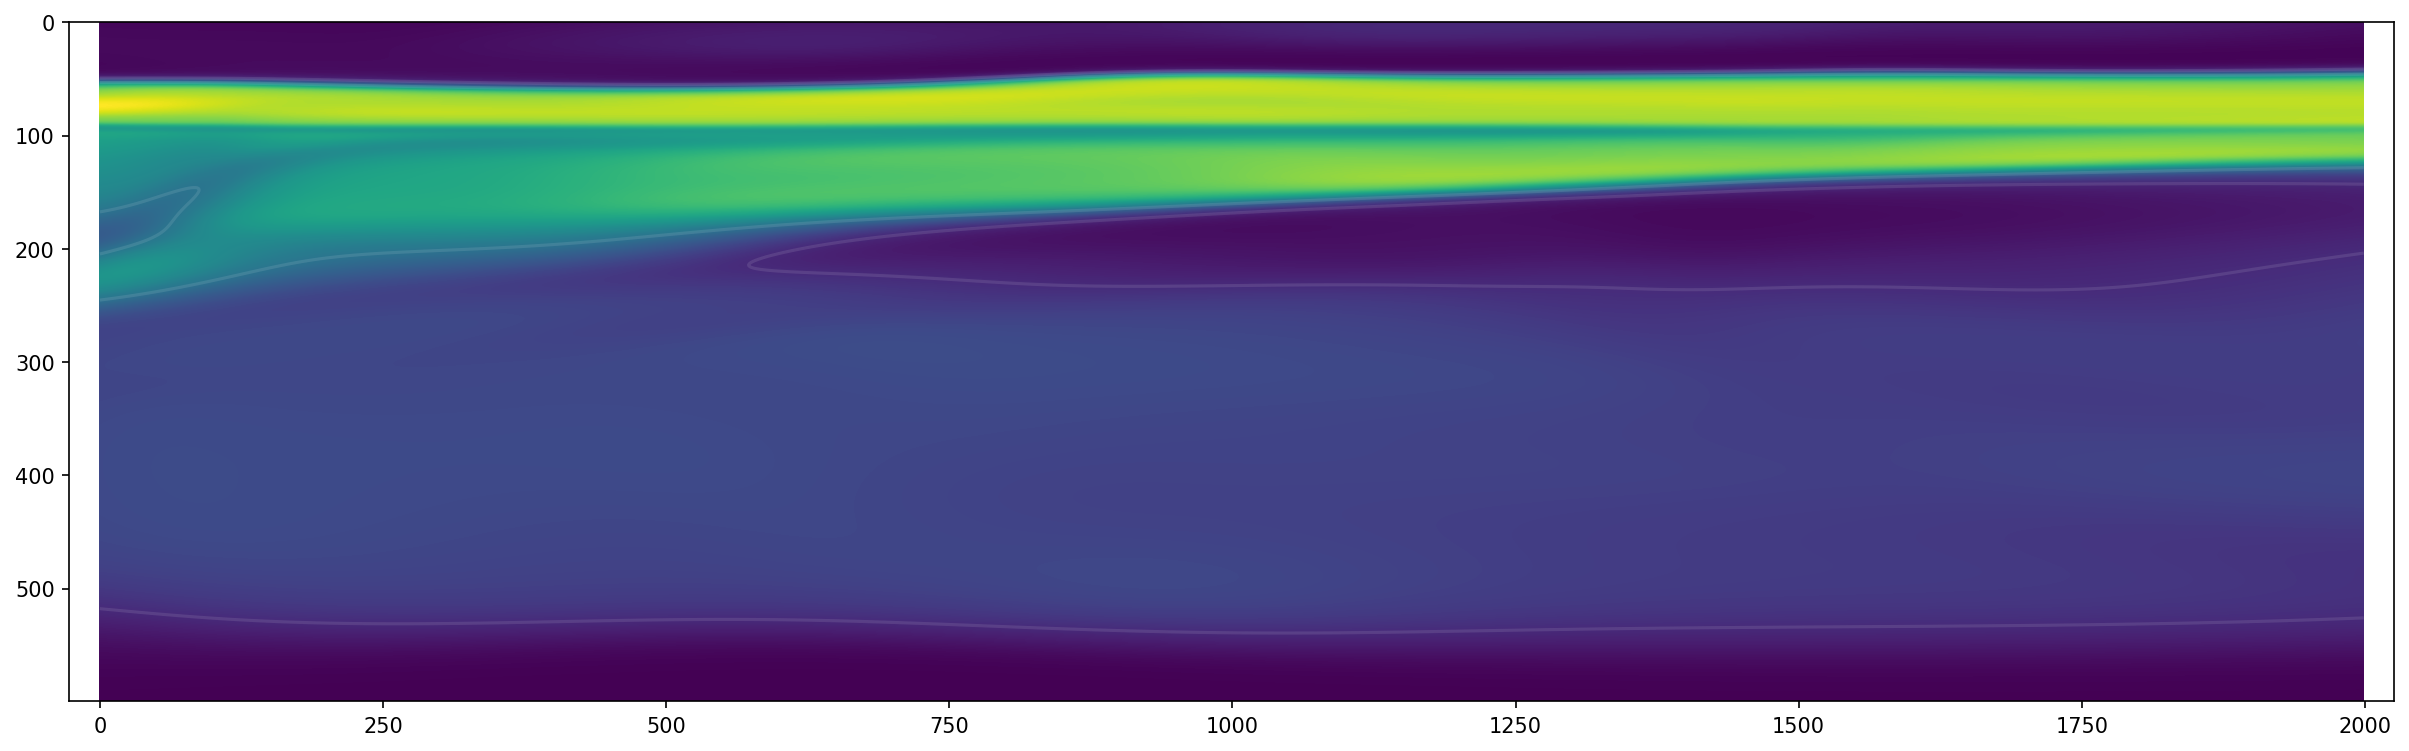

In [ ]:
def model_xsec(model, scale=1):
  # rangeX = np.linspace(xmin, xmax, 100)
  zpx = int(600*scale)
  ypx = int(2000*scale)

  rangeY = np.linspace(ymin, ymax, ypx)
  rangeZ = np.linspace(zmin, zmax, zpx)


  imY, imZ = np.meshgrid(rangeY, rangeZ)
  imYf, imZf  = imY.flatten(), imZ.flatten()
  print(imY.shape)

  imsamp3 = np.vstack((imZf*0,imYf,imZf)).T

  y_impred3darkf  = model.predict(imsamp3, batch_size=8192)

  y_impred3dark = np.flipud(y_impred3darkf.reshape(zpx,ypx))


  plt.rcParams['figure.dpi'] = 150
  fig=plt.figure(figsize=(20, 6))
  plt.axis('equal')
  plt.plot()
  plt.imshow(y_impred3dark)
  plt.contour(y_impred3dark, levels=np.logspace(-1, 1, 5), colors='white', alpha=.1)
  return y_impred3dark

y_impred3dark = model_xsec(modelDark)

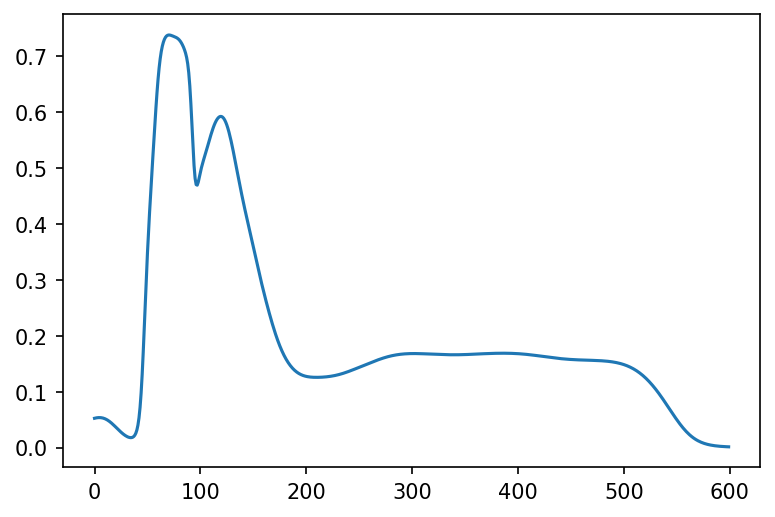

In [ ]:
y_impred3dark_trend = y_impred3dark.mean(axis=1)
plt.plot(y_impred3dark_trend)

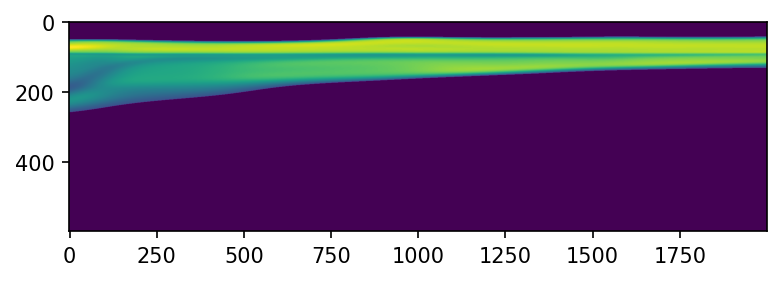

In [ ]:
y_impred3dark_masked =  y_impred3dark.copy()
y_impred3dark_masked[y_impred3dark_masked<.2]=0
plt.imshow(y_impred3dark_masked)


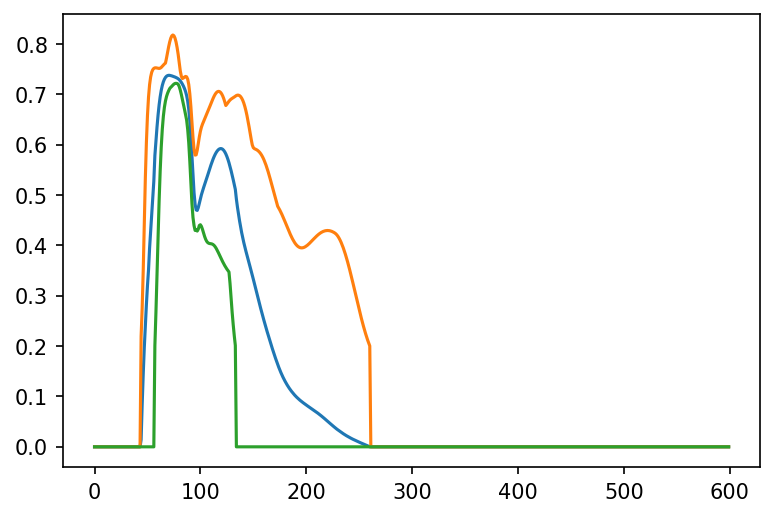

In [ ]:
y_impred3dark_masked_mean = y_impred3dark_masked.mean(axis=1)
y_impred3dark_masked_max = y_impred3dark_masked.max(axis=1)
y_impred3dark_masked_min = y_impred3dark_masked.min(axis=1)
plt.plot(y_impred3dark_masked_mean)
plt.plot(y_impred3dark_masked_max)
plt.plot(y_impred3dark_masked_min)

2174/2174 [==============================] - 8s 4ms/step - loss: 0.0206
(600, 2000)
147/147 [==============================] - 1s 3ms/step


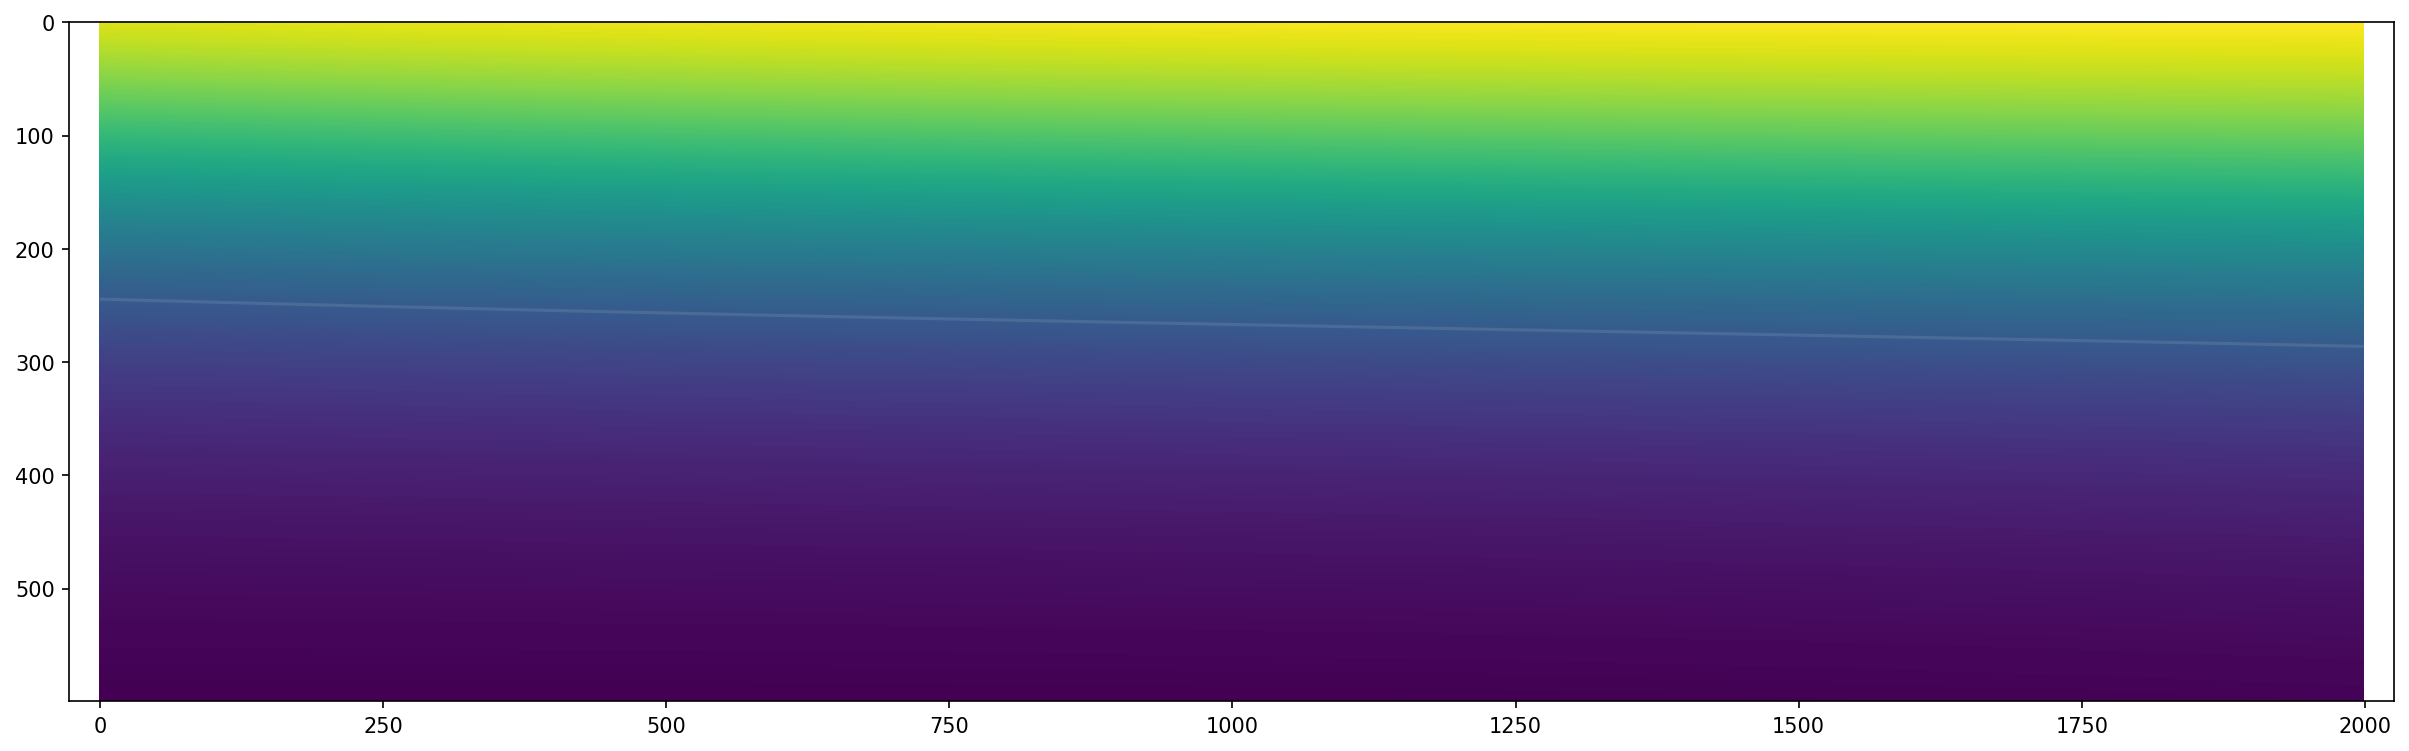

In [ ]:
def quick_nerfdar(p, i, e=1):
  model2 = make_model(activation, inputs=p.shape[1])
  model2.compile(loss='mse', optimizer='adam')
  model2.fit(p, i, batch_size=1024, epochs=e)
  model_xsec(model2, scale=1)


quick_nerfdar(X_dark,intensity_dark)

In [ ]:
def Xpad_sin(x, loops = 1):
  print_stats(x)
  x[:,2]*=1
  # print(x[:,2])
  xnorm = x/x.max()
  # print_stats(xnorm)
  looped = []
  for i in range(loops):

    looped.append(np.sin(i*xnorm))
  # plt.plot(sin1[:200,0])
  return np.hstack((xnorm,*looped))
  # return xnorm

test = Xpad_sin(X_dark)
print(test.shape)

0 0.0 0.4902031997091891 1.0
1 0.0 0.479367054786688 1.0
2 0.0 0.7364757830508367 1.0

(2225383, 6)


In [ ]:
p = Xpad_sin(X_dark,loops=50)
i = intensity_dark
e = 5
print(p.shape)
model3 = make_model(activation, inputs=p.shape[1])
model3.compile(loss='mse', optimizer='adam')
model3.fit(p, i, batch_size=1024, epochs=e)

0 0.0 0.4902031997091891 1.0
1 0.0 0.479367054786688 1.0
2 0.0 0.7364757830508367 1.0

(2225383, 153)
Epoch 1/5
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0108
Epoch 2/5
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0093
Epoch 3/5
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0090
Epoch 4/5
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0088
Epoch 5/5
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0086


(600, 2000)
0 0.0 0.0 0.0
1 0.0 0.4999999999999999 1.0
2 0.0 0.5000000000000001 1.0

(1200000, 153)
147/147 [==============================] - 1s 5ms/step


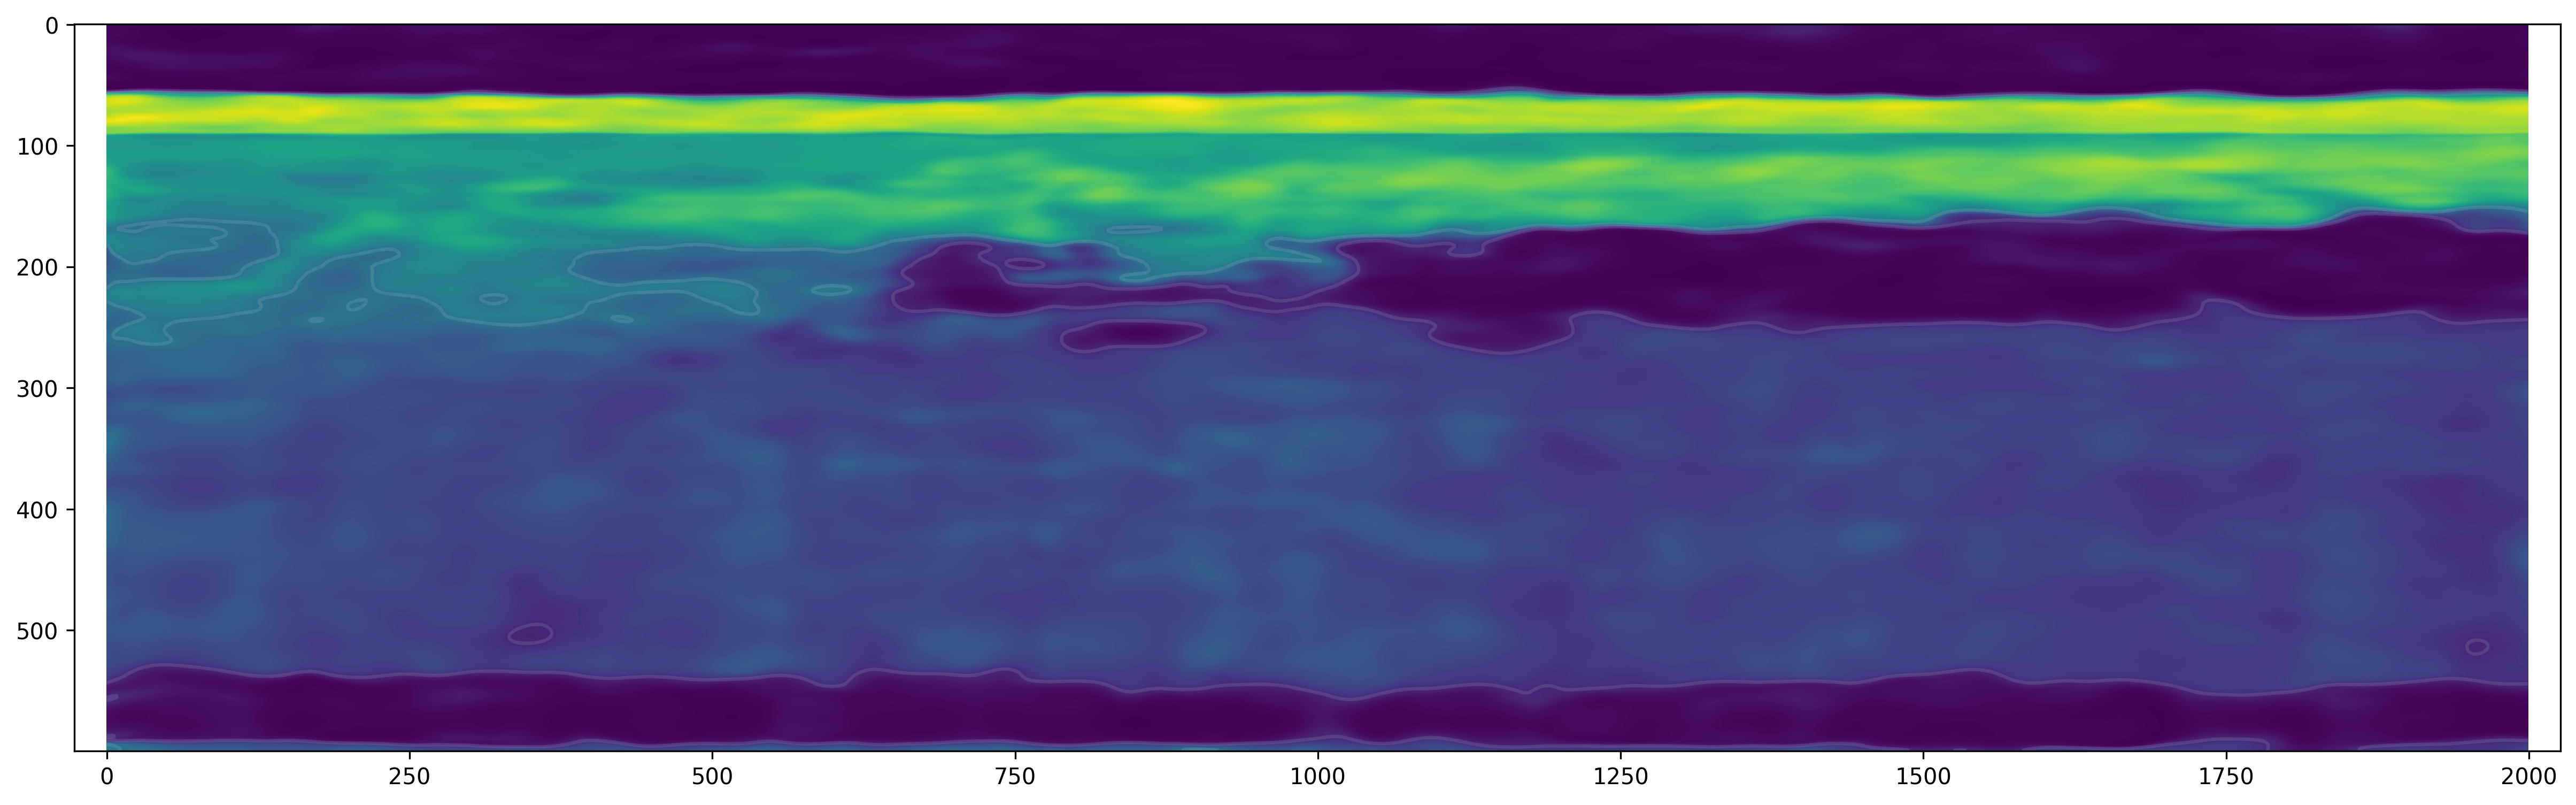

In [ ]:
def model_xsec_sin(model, scale=1, loops = 1):
  # rangeX = np.linspace(xmin, xmax, 100)
  zpx = int(600*scale)
  ypx = int(2000*scale)

  rangeY = np.linspace(ymin, ymax, ypx)
  rangeZ = np.linspace(zmin, zmax, zpx)


  imY, imZ = np.meshgrid(rangeY, rangeZ)
  imYf, imZf  = imY.flatten(), imZ.flatten()
  print(imY.shape)

  imsamp3 = np.vstack((imZf*+.1,imYf,imZf)).T

  imsamp3 = Xpad_sin(imsamp3,loops)

  print(imsamp3.shape)

  y_impred3darkf  = model.predict(imsamp3, batch_size=8192)

  y_impred3dark = np.flipud(y_impred3darkf.reshape(zpx,ypx))


  plt.rcParams['figure.dpi'] = 300
  fig=plt.figure(figsize=(20, 6))
  plt.axis('equal')
  plt.plot()
  plt.imshow(y_impred3dark)
  plt.contour(y_impred3dark, levels=np.logspace(-1, 1, 5), colors='white', alpha=.1)

model_xsec_sin(model3,scale=1,loops=50)

In [ ]:
model3.fit(p, i, batch_size=1024, epochs=25)

Epoch 1/25
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0084
Epoch 2/25
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0083
Epoch 3/25
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0081
Epoch 4/25
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0080
Epoch 5/25
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0079
Epoch 6/25
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0078
Epoch 7/25
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0077
Epoch 8/25
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0077
Epoch 9/25
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0076
Epoch 10/25
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0075
Epoch 11/25
2174/2174 [==============================] - 9s 4ms/step - loss: 0.0075
Epoch 12/25
2174/2174 [==============================] - 11s 5ms/step - loss: 0.0074


(600, 2000)
0 0.0 0.0 0.0
1 0.0 0.4999999999999999 1.0
2 0.0 0.5000000000000001 1.0

(1200000, 153)
147/147 [==============================] - 1s 5ms/step


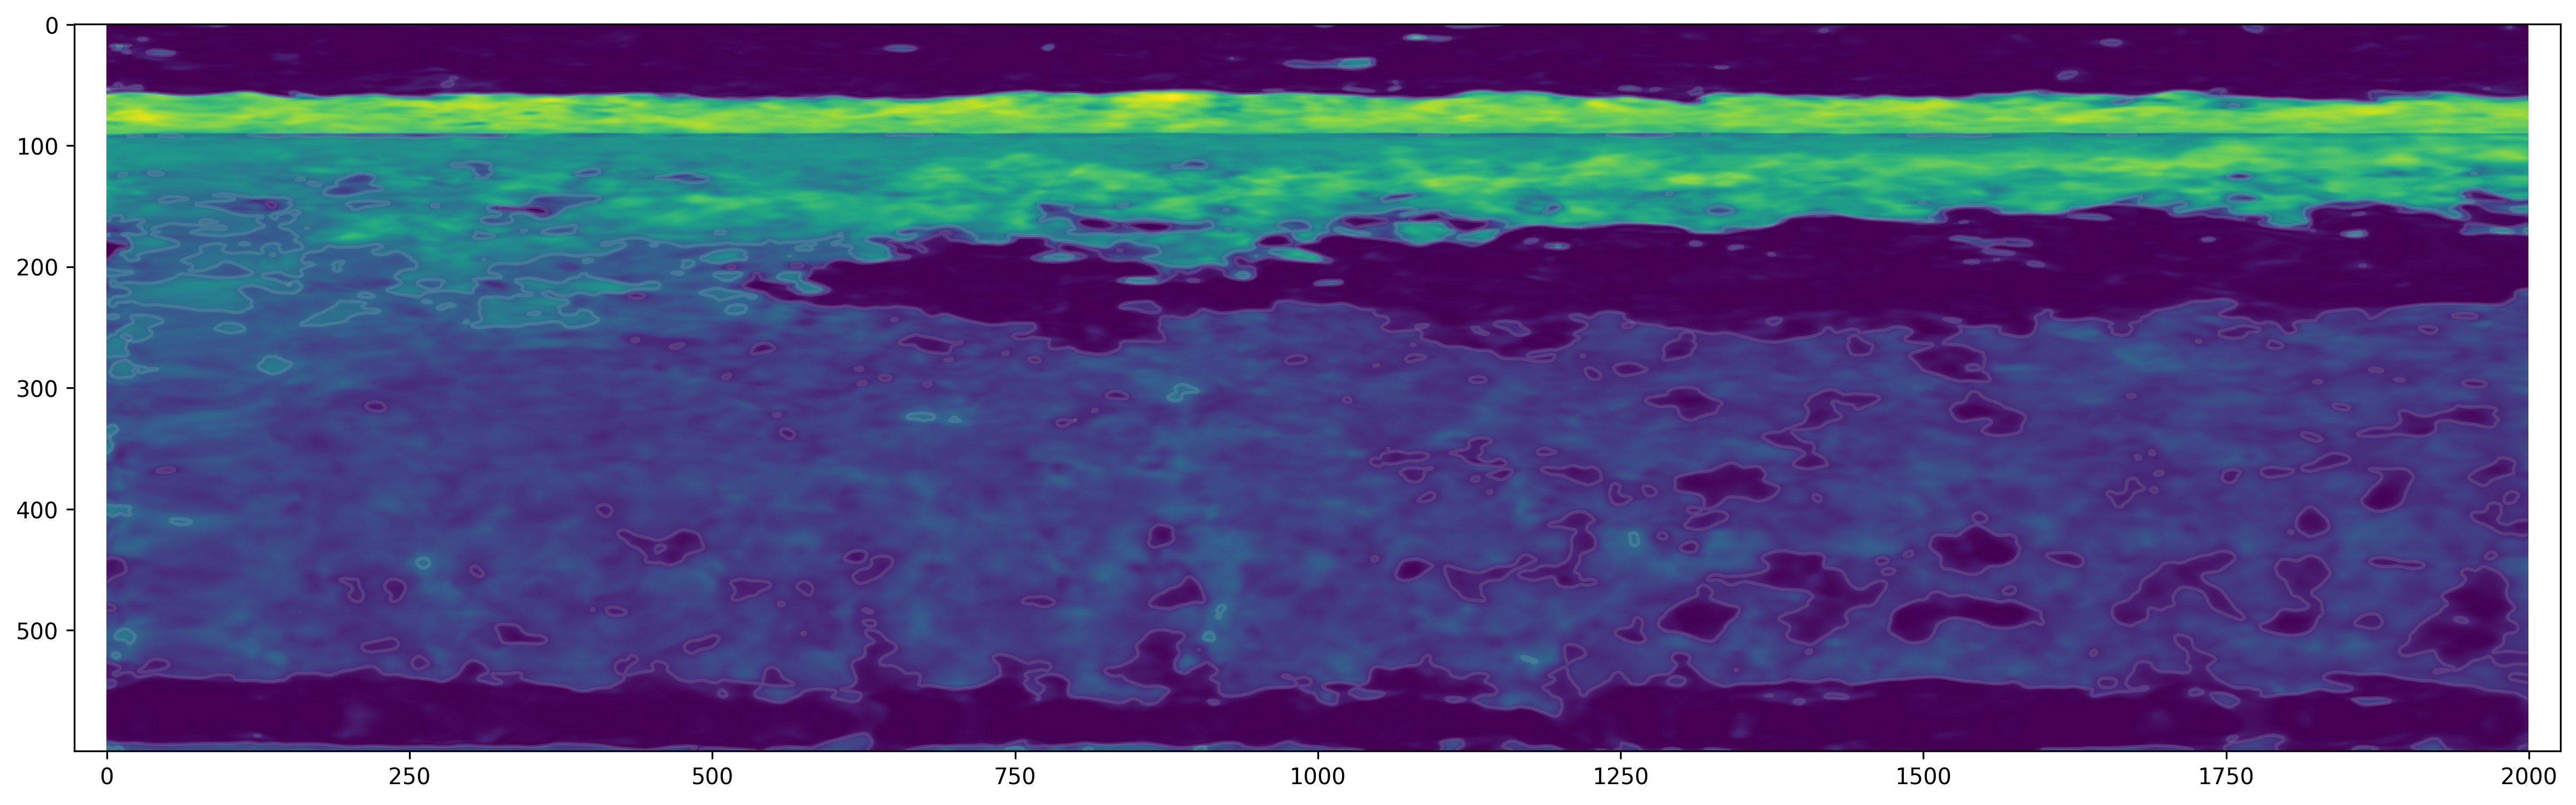

In [ ]:
model_xsec_sin(model3,scale=1,loops=50)